<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 04/01/2026</span>
    <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/sagaTrip/blob/main/nbs/10_BenchmarkingTOkenizer4Odia.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    </p>
</div>

## Introduction

Large Language Models (LLMs) process text as **tokens**, not characters or words. The tokenizer — which converts text to tokens — is foundational to how well a model handles any language.

An effective tokenizer should contain **subwords** that meaningfully represent the language. For English, tokenizers typically learn common morphemes like "ing", "tion", "pre-". But for many Indic languages, tokenizers trained primarily on English data fall back to **byte-level encoding** — treating each UTF-8 byte as a separate token.

**Odia** (ଓଡ଼ିଆ) is an Eastern Indic language spoken by ~40 million people in India. Despite being a classical language with a rich literary history, Odia is severely **underrepresented on the web** — falling into the <0.1% category of internet content. For comparison, even Hindi (the third most-spoken language globally) accounts for only 0.07% of web domains. This means most LLM tokenizers have seen very little Odia text during training.


This has real consequences:

- **Higher costs** — Same text uses 3-5x more tokens in API calls
- **Reduced context** — Less information fits in the context window  
- **Potentially worse performance** — The model sees fragmented bytes, not meaningful units

In this evaluation, we compare how popular open-source LLM tokenizers handle Odia using the `OdiaGenAI/dolly-odia-15k` dataset.


In [ ]:
#|hide
#!pip install -q transformers datasets  -U

In [ ]:

import pandas as  pd
from datasets import load_dataset
import matplotlib.pyplot as plt
#from huggingface_hub import login
#login()

## Dataset

We use `OdiaGenAI/dolly-odia-15k`, an Odia language dataset suitable for supervised fine-tuning (SFT). We sample 1000 examples for evaluation.

In [ ]:
ds = load_dataset("OdiaGenAI/dolly-odia-15k")
ds

README.md: 0.00B [00:00, ?B/s]

translated-databricks-dolly-15k.json:   0%|          | 0.00/40.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15005 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['english_context', 'response', 'context', 'instruction', 'english_response', 'english_instruction', 'category', 'english_category'],
        num_rows: 15005
    })
})

In [ ]:
ds['train'][0]

{'english_context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]",
 'response': 'ଭର୍ଜିନ୍ ଅଷ୍ଟ୍ରେଲିଆ 2000 ମସିହା ଅଗଷ୍ଟ 31 ତାରିଖରେ ଭର୍ଜିନ୍ ବ୍ଲୁ ନାମରେ ଦୁଇଟି ବିମାନ ସହିତ ଗୋଟିଏ ରୁଟରେ ବିମାନ ସେବା ଆରମ୍ଭ କରିଥିଲା।',
 'context': 'ଭର୍ଜିନ ଅଷ୍ଟ୍ରେଲିଆ ହେଉଛି ଅଷ୍ଟ୍ରେଲିଆର ଏକ ଏୟାରଲାଇନ୍ସ କମ୍ପାନୀ। ଭିର୍ଜିନ୍ ବ୍ରାଣ୍ଡର ବ୍ୟବହାର କରୁଥିବା ଏହା ହେଉଛି ବିଶ୍ୱର ସର୍ବବୃହତ ବିମାନ ସେବା। ସେପ୍ଟେମ୍ବର 2001ରେ ଆନ୍ସେଟ୍ ଅଷ୍ଟ୍ରେଲିଆ ଭାଙ୍ଗିଯିବା ପରେ ଏହା ହଠାତ୍ ଅଷ୍ଟ୍ରେଲିଆର ଘରୋଇ ବଜାରରେ ଏକ ପ୍ରମୁଖ ଏୟାରଲାଇନ୍ସ ଭାବେ ଉଭା ହୋଇଥିଲା। ଏହାପରେ ଏହି ବିମାନ ସେବା ବ୍ରିସବେନ, ମେଲବୋର୍ଣ୍ଣ ଏବଂ ସିଡନୀରେ

Lets remove unnecessary columns from the datasets.

In [ ]:
c2drop = ['english_context', 'english_response', 'english_instruction', 'category', 'english_category']
ds = ds.remove_columns(c2drop)
ds

DatasetDict({
    train: Dataset({
        features: ['response', 'context', 'instruction'],
        num_rows: 15005
    })
})

We will consolidate the columns containing Odia so that we can run our eval. Combining response, context, and instruction into a single text column will make it easier.

In [ ]:
def consolidate(x):
    return {"text": x['response'] + " " + x['context'] + " " + x['instruction']}

ds = ds.map(consolidate, remove_columns=['response', 'context', 'instruction'])
ds

Map:   0%|          | 0/15005 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 15005
    })
})

In [ ]:
ds = ds['train'].shuffle(seed=42).select(range(1000))
ds


Dataset({
    features: ['text'],
    num_rows: 1000
})

## Models

We compare tokenizers from state-of-the-art open source LLMs:

- **Indic-focused**: sarvam-1, Krutrim-2-instruct
- **Multilingual**: Qwen3, Gemma 2/3
- **English-centric**: LLaMA 3, GPT-oss

Few models might need permission. Please login to HuggingFace and  accept license.

In [ ]:
models = [
    # Indic
    'krutrim-ai-labs/Krutrim-2-instruct',
    'sarvamai/sarvam-1',
    # OpenAI
    'openai/gpt-oss-20b',
    # Qwen
    'Qwen/Qwen3-8B',
    # Google
    'google/gemma-2-9b',
    'google/gemma-3-12b-it',
    # Meta
    'meta-llama/Meta-Llama-3-8B-Instruct',
]


In [ ]:
from transformers import AutoTokenizer

tokenizers = {}
for model in models:
    try:
        tokenizers[model] = AutoTokenizer.from_pretrained(model)
        print(f"Loaded {model}")
    except Exception as e:
        print(f"Failed {model}: {e}")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Loaded krutrim-ai-labs/Krutrim-2-instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loaded sarvamai/sarvam-1


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Loaded openai/gpt-oss-20b


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded Qwen/Qwen3-8B


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded google/gemma-2-9b


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Loaded google/gemma-3-12b-it


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Loaded meta-llama/Meta-Llama-3-8B-Instruct


In [ ]:
tokenizers.keys()

dict_keys(['krutrim-ai-labs/Krutrim-2-instruct', 'sarvamai/sarvam-1', 'openai/gpt-oss-20b', 'Qwen/Qwen3-8B', 'google/gemma-2-9b', 'google/gemma-3-12b-it', 'meta-llama/Meta-Llama-3-8B-Instruct'])

## Metrics

1. **Fertility** — `tokens / words`. Measures how efficiently a tokenizer represents text. Lower is better.
1. **Vocabulary Coverage** — Percentage of Odia characters present in the tokenizer's vocabulary vs treated as unknown or byte-fallback. Higher is better.
1. **Compression Ratio** — `bytes / tokens`. Measures information density per token. Higher is better (lower API costs, more efficient context usage).
1. **Roundtrip Accuracy** — Does `decode(encode(text)) == text`? Tests whether any information is lost during tokenization.

### Fertility

- Calculate `number_of_words` from a given text to words, i.e. no of whitespace
- then use : `fertility = number_of_tokens / number_of_words`


In [ ]:
t = ds[0]['text']
t

'ଏହା ସୁନିଶ୍ଚିତ କରନ୍ତୁ ଯେ ଆପଣମାନେ ନିଜର ଗବେଷଣା ଅଂଶଗ୍ରହଣକାରୀଙ୍କୁ କ୍ଷତି ପହଞ୍ଚାଉନାହାନ୍ତି, ଏଥିସହିତ ଲାଭ ବଢ଼ାଉଛନ୍ତି ଏବଂ କୌଣସି ସମ୍ଭାବ୍ୟ କ୍ଷତି ହ୍ରାସ କରୁଛନ୍ତି। ନୈତିକ ଚିନ୍ତାକୁ ସାମ୍ନା କରିବା ସମୟରେ ସର୍ବଶ୍ରେଷ୍ଠ ପ୍ରଚଳନ ନିର୍ଦ୍ଧାରଣ କରିବା ପାଇଁ ନିଜ ସମୁଦାୟ ସହିତ ଯୋଡ଼ି ହୁଅନ୍ତୁ। ଏହାଦ୍ୱାରା ଆପଣମାନଙ୍କୁ ଲାଭ ମିଳିବା ସୁନିଶ୍ଚିତ ହୋଇପାରିବ। ବେଲ୍ମଣ୍ଟ ରିପୋର୍ଟ ଅନୁଯାୟୀ, ଗବେଷକମାନଙ୍କୁ ‘ଲାଭ’ ନୀତି ଅନୁଯାୟୀ ଦୁଇଟି ନୈତିକ ଆବଶ୍ୟକତାକୁ ପାଳନ କରିବାକୁ ପଡ଼ିବଃ ଅନ୍ୟମାନଙ୍କର କୌଣସି ସମ୍ଭାବ୍ୟ କ୍ଷତିକୁ ହ୍ରାସ କରିବା ସମୟରେ ‘କ୍ଷତି ନ କରିବା ଏବଂ ଗବେଷଣା ପାଇଁ ସର୍ବାଧିକ ଲାଭ’। [1]\nଚିକିତ୍ସା ପେସାଦାର ଏବଂ ଗବେଷକମାନେ ସର୍ବଦା ଲାଭପ୍ରଦ ଚିକିତ୍ସା ଅଭ୍ୟାସ କରିବେ ବୋଲି ଧାରଣା ଅଧିକାଂଶ ରୋଗୀ ଏବଂ ଗବେଷଣା ଅଂଶଗ୍ରହଣକାରୀଙ୍କ ପାଇଁ ସ୍ୱାଭାବିକ ଲାଗୁଛି, କିନ୍ତୁ ବାସ୍ତବରେ, ପ୍ରତ୍ୟେକ ସ୍ୱାସ୍ଥ୍ୟ ହସ୍ତକ୍ଷେପ କିମ୍ବା ଗବେଷଣା ହସ୍ତକ୍ଷେପର ଗ୍ରହଣକାରୀକୁ କ୍ଷତି ପହଞ୍ଚାଇବାର ସମ୍ଭାବନା ରହିଛି।\nମତପାର୍ଥକ୍ୟ ସତ୍ତ୍ୱେ, ଏଭଳି ଅନେକ ଚିନ୍ତାଧାରା ରହିଛି ଯାହାକୁ ନେଇ ବ୍ୟାପକ ସହମତି ରହିଛି। ଲାଭ ସମ୍ବନ୍ଧରେ ଏହି ସନ୍ଦର୍ଭକୁ ଦୃଷ୍ଟିରେ ରଖି ମୁଁ କ’ଣ କରିପାରିବି?'

Find the number of words for a given statement.

In [ ]:
def num_words(x):
    return {"num_words" : len(x['text'].split())}

ds = ds.map(num_words)
ds

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'num_words'],
    num_rows: 1000
})

Tokenize the `text` and divide wrt the word count in the text.

In [ ]:
def fertilities(x):
    result = {}
    for name, tok in tokenizers.items():
        token_ids = tok(x['text'])['input_ids']  # list of lists
        result[f"{name}"] = [
            len(ids) / nw
            for ids, nw in zip(token_ids, x['num_words'])
        ]
    return result

ds = ds.map(fertilities, batched=True)
ds

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (7970 > 4096). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['text', 'num_words', 'krutrim-ai-labs/Krutrim-2-instruct', 'sarvamai/sarvam-1', 'openai/gpt-oss-20b', 'Qwen/Qwen3-8B', 'google/gemma-2-9b', 'google/gemma-3-12b-it', 'meta-llama/Meta-Llama-3-8B-Instruct'],
    num_rows: 1000
})

Bar graph from the ds. For all the columns except of `['text', 'num_words']`.

In [ ]:
def plot_metric(ds, title, xlabel, remove_cols=['text'], ascending=True):
    df = ds.remove_columns(remove_cols).to_pandas()
    ax = df.mean().sort_values(ascending=ascending).plot.barh()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.tight_layout()
    return df.mean().sort_values(ascending=ascending)


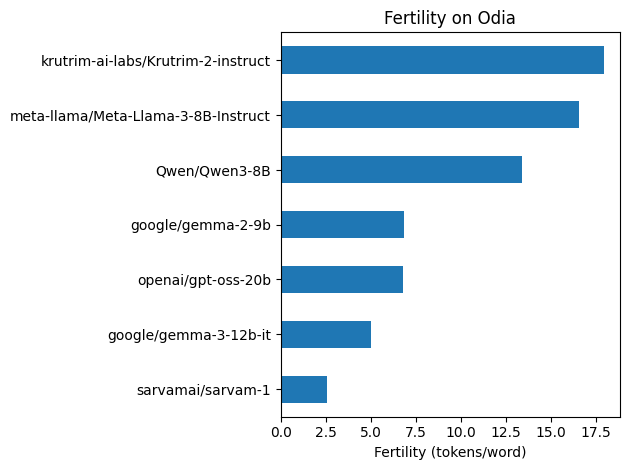

In [ ]:
fertility_df = plot_metric(
    ds,
    'Fertility on Odia',
    'Fertility (tokens/word)',
    remove_cols=['text', 'num_words']
)


**Key Findings:**

1. **Sarvam-1 wins** — The Indic-focused model has the best fertility at ~2.6 tokens/word, significantly outperforming all others.

2. **Gemma 3 is runner-up** — At ~5.1 tokens/word, it's the best among non-Indic models.

3. **Krutrim-2 underperforms** — Despite being Indic-focused, it shows the worst fertility (~18 tokens/word), suggesting it may use byte-fallback for Odia.

4. **7x cost difference** — Using Krutrim-2 or LLaMA 3 for Odia would cost ~7x more in tokens compared to Sarvam-1.


In [ ]:
ds.column_names

['text',
 'num_words',
 'krutrim-ai-labs/Krutrim-2-instruct',
 'sarvamai/sarvam-1',
 'openai/gpt-oss-20b',
 'Qwen/Qwen3-8B',
 'google/gemma-2-9b',
 'google/gemma-3-12b-it',
 'meta-llama/Meta-Llama-3-8B-Instruct']

In [ ]:
ds = ds.remove_columns(ds.column_names[1:])
ds

Dataset({
    features: ['text'],
    num_rows: 1000
})

### Vocabulary Coverage


**Vocabulary Coverage** measures how many Odia characters are actually in each tokenizer's vocabulary vs treated as unknown/bytes.

The approach:
1. **Odia characters**: consonants (କ, ଖ, ଗ...), vowels (ଅ, ଆ, ଇ...), matras (ା, ି, େ...), virama (୍), Odia digits (୦, ୧...). Use unicodedata to filter, just Odia Unicode characters (range `0x0B00` to `0x0B7F`).
2. For each tokenizer, check which characters exist as single tokens in the vocab
3. Calculate: `coverage = chars_in_vocab / total_unique_chars`


In [ ]:
import unicodedata

odia_chars = []
for i in range(0x0B00, 0x0B80):
    c = chr(i)
    try:
        name = unicodedata.name(c)
        odia_chars.append(c)
    except ValueError:
        pass  # unassigned codepoint

len(odia_chars), odia_chars[:5]

(91, ['ଁ', 'ଂ', 'ଃ', 'ଅ', 'ଆ'])

In [ ]:
dic = {}

for name, tok in tokenizers.items():
    vocab = tok.vocab.keys()
    dic[name] = [i in vocab for i in odia_chars]

In [ ]:
cov = {name: sum(vals)/len(vals)*100 for name, vals in dic.items()}
cov


{'krutrim-ai-labs/Krutrim-2-instruct': 0.0,
 'sarvamai/sarvam-1': 63.73626373626373,
 'openai/gpt-oss-20b': 0.0,
 'Qwen/Qwen3-8B': 0.0,
 'google/gemma-2-9b': 74.72527472527473,
 'google/gemma-3-12b-it': 75.82417582417582,
 'meta-llama/Meta-Llama-3-8B-Instruct': 0.0}

Text(0.5, 1.0, 'Vocabulary Coverage on Odia (single characters)')

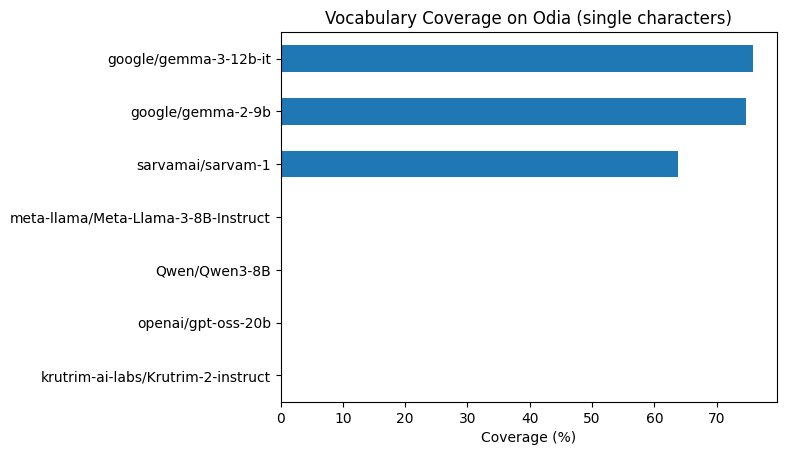

In [ ]:
ax = pd.Series(cov).sort_values().plot.barh()
ax.set_xlabel('Coverage (%)')
ax.set_title('Vocabulary Coverage on Odia (single characters)')

Only **Gemma** models (2-9b and 3-12b) include individual Odia characters in their vocabulary (~75% coverage). All other tokenizers show 0% single-character coverage, relying instead on byte-level fallback or learned subwords.


### Odia subwords

These tokenizers might have multi-character tokens like "କର" or "ମାନ" even without single characters. Lets count those.

In [ ]:
vocab = list(vocab)
vocab[:4]

['Ġoverwrite', 'áº©n', 'ĠØ±ÙĪØ³ÛĮ', 'ĠMÃ¤dchen']

Chekc if a char falls between '\u0B00' and '\u0B7F'.

In [ ]:
def has_odia(token):
    return any('\u0B00' <= c <= '\u0B7F' for c in token)
has_odia("କ"), has_odia("କର"), has_odia("hello")


(True, True, False)

In [ ]:
odia_counts = {}
for name, tok in tokenizers.items():
    odia_counts[name] = sum(1 for t in tok.vocab if has_odia(t))

odia_counts

{'krutrim-ai-labs/Krutrim-2-instruct': 0,
 'sarvamai/sarvam-1': 1956,
 'openai/gpt-oss-20b': 0,
 'Qwen/Qwen3-8B': 0,
 'google/gemma-2-9b': 69,
 'google/gemma-3-12b-it': 125,
 'meta-llama/Meta-Llama-3-8B-Instruct': 0}

**Sarvam-1 has by far the most Odia subwords (1956)**, explaining its excellent fertility. Gemma models have some (69-125), while other models have zero — they rely entirely on byte-level fallback for Odia text.

### Compression Ratio (bytes per token)

- `compression = len(text.encode('utf-8')) / num_tokens`
- Higher = more efficient (more bytes packed per token)


In [ ]:
def tokens_count(x):
    result = {}
    for name, tok in tokenizers.items():
        token_ids = tok(x['text'])['input_ids']            # list of lists
        utfs = [i.encode('utf-8') for i in x['text']]      # encode the string utf-8
        comp = [
            len(b) / len(ids)
            for ids, b in zip(token_ids, utfs)
        ]
        result[f"{name}"] = comp
    return result

ds = ds.map(tokens_count, batched=True)
ds

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'krutrim-ai-labs/Krutrim-2-instruct', 'sarvamai/sarvam-1', 'openai/gpt-oss-20b', 'Qwen/Qwen3-8B', 'google/gemma-2-9b', 'google/gemma-3-12b-it', 'meta-llama/Meta-Llama-3-8B-Instruct'],
    num_rows: 1000
})

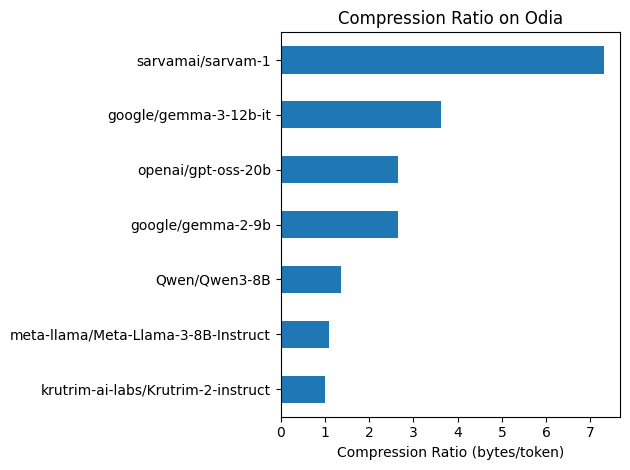

In [ ]:
compression_df = plot_metric(
    ds,
    'Compression Ratio on Odia',
    'Compression Ratio (bytes/token)',
)


**Key Findings:**

1. **Sarvam-1 dominates** — At ~7.3 bytes/token, it packs far more information per token than any other model, thanks to its 1956 learned Odia subwords.

2. **Gemma 3 is runner-up** — At ~3.6 bytes/token, it's the best non-Indic model.

3. **Krutrim-2 & LLaMA 3 at ~1.0 bytes/token** — This confirms they're using pure byte-fallback encoding for Odia (each UTF-8 byte becomes a separate token).

4. **Practical impact**: For the same Odia text:
   - Sarvam-1: 100 tokens
   - Gemma 3: ~200 tokens
   - Krutrim-2/LLaMA 3: ~730 tokens


### Roundtrip accuracy

Does decode(encode(text)) == text


In [ ]:
s = ds['text'][0]
s_ = tok.decode(tok.encode(s), skip_special_tokens=True) # remove special tokens during decoding
s, s_

('ଏହା ସୁନିଶ୍ଚିତ କରନ୍ତୁ ଯେ ଆପଣମାନେ ନିଜର ଗବେଷଣା ଅଂଶଗ୍ରହଣକାରୀଙ୍କୁ କ୍ଷତି ପହଞ୍ଚାଉନାହାନ୍ତି, ଏଥିସହିତ ଲାଭ ବଢ଼ାଉଛନ୍ତି ଏବଂ କୌଣସି ସମ୍ଭାବ୍ୟ କ୍ଷତି ହ୍ରାସ କରୁଛନ୍ତି। ନୈତିକ ଚିନ୍ତାକୁ ସାମ୍ନା କରିବା ସମୟରେ ସର୍ବଶ୍ରେଷ୍ଠ ପ୍ରଚଳନ ନିର୍ଦ୍ଧାରଣ କରିବା ପାଇଁ ନିଜ ସମୁଦାୟ ସହିତ ଯୋଡ଼ି ହୁଅନ୍ତୁ। ଏହାଦ୍ୱାରା ଆପଣମାନଙ୍କୁ ଲାଭ ମିଳିବା ସୁନିଶ୍ଚିତ ହୋଇପାରିବ। ବେଲ୍ମଣ୍ଟ ରିପୋର୍ଟ ଅନୁଯାୟୀ, ଗବେଷକମାନଙ୍କୁ ‘ଲାଭ’ ନୀତି ଅନୁଯାୟୀ ଦୁଇଟି ନୈତିକ ଆବଶ୍ୟକତାକୁ ପାଳନ କରିବାକୁ ପଡ଼ିବଃ ଅନ୍ୟମାନଙ୍କର କୌଣସି ସମ୍ଭାବ୍ୟ କ୍ଷତିକୁ ହ୍ରାସ କରିବା ସମୟରେ ‘କ୍ଷତି ନ କରିବା ଏବଂ ଗବେଷଣା ପାଇଁ ସର୍ବାଧିକ ଲାଭ’। [1]\nଚିକିତ୍ସା ପେସାଦାର ଏବଂ ଗବେଷକମାନେ ସର୍ବଦା ଲାଭପ୍ରଦ ଚିକିତ୍ସା ଅଭ୍ୟାସ କରିବେ ବୋଲି ଧାରଣା ଅଧିକାଂଶ ରୋଗୀ ଏବଂ ଗବେଷଣା ଅଂଶଗ୍ରହଣକାରୀଙ୍କ ପାଇଁ ସ୍ୱାଭାବିକ ଲାଗୁଛି, କିନ୍ତୁ ବାସ୍ତବରେ, ପ୍ରତ୍ୟେକ ସ୍ୱାସ୍ଥ୍ୟ ହସ୍ତକ୍ଷେପ କିମ୍ବା ଗବେଷଣା ହସ୍ତକ୍ଷେପର ଗ୍ରହଣକାରୀକୁ କ୍ଷତି ପହଞ୍ଚାଇବାର ସମ୍ଭାବନା ରହିଛି।\nମତପାର୍ଥକ୍ୟ ସତ୍ତ୍ୱେ, ଏଭଳି ଅନେକ ଚିନ୍ତାଧାରା ରହିଛି ଯାହାକୁ ନେଇ ବ୍ୟାପକ ସହମତି ରହିଛି। ଲାଭ ସମ୍ବନ୍ଧରେ ଏହି ସନ୍ଦର୍ଭକୁ ଦୃଷ୍ଟିରେ ରଖି ମୁଁ କ’ଣ କରିପାରିବି?',
 'ଏହା ସୁନିଶ୍ଚିତ କରନ୍ତୁ ଯେ ଆପଣମାନେ ନିଜର ଗବେଷଣା ଅଂଶଗ୍ରହଣକାରୀଙ୍କୁ କ୍ଷତି ପହଞ୍ଚାଉନାହାନ୍ତି, ଏଥ

In [ ]:
def round_acc(x):
    result = {}
    for name, tok in tokenizers.items():
        result[f"{name}"] = [
            int(s == tok.decode(tok.encode(s), skip_special_tokens=True) )
            for s in x['text']]
    return result

ds = ds.map(round_acc, batched=True)
ds


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'krutrim-ai-labs/Krutrim-2-instruct', 'sarvamai/sarvam-1', 'openai/gpt-oss-20b', 'Qwen/Qwen3-8B', 'google/gemma-2-9b', 'google/gemma-3-12b-it', 'meta-llama/Meta-Llama-3-8B-Instruct'],
    num_rows: 1000
})

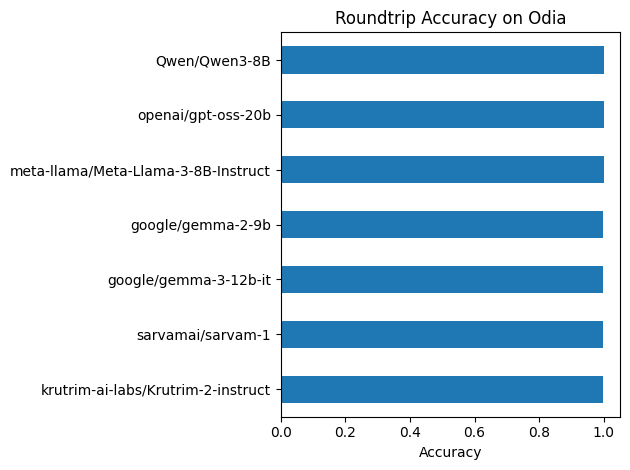

In [ ]:
roundtrip_df = plot_metric(
    ds,
    'Roundtrip Accuracy on Odia',
    'Accuracy',
)

All models achieve **≥99.7% roundtrip accuracy** — effectively lossless. The few failures (~0.3%) likely involve rare characters or edge cases in the dataset.

### Vibe check

In [ ]:
import html

def color_tokens(text, tokenizer):
    colors = [
    '#FF6B6B',  # coral red
    '#4ECDC4',  # teal
    '#FFE66D',  # yellow
    '#95E1D3',  # mint
    '#F38181',  # salmon
    '#AA96DA',  # lavender
    '#81C784',  # green
    '#FFB74D',  # orange
    '#64B5F6',  # blue
    '#F06292',  # pink
    ]

    tokens = tokenizer.tokenize(text)
    html_parts = []
    for i, tok in enumerate(tokens):
        color = colors[i % len(colors)]
        html_parts.append(f'<span style="background:{color}; color:black; padding:2px; margin:1px; border-radius:3px">{html.escape(tok)}</span>')
    return f'<div style="font-size:18px; line-height:2">{"".join(html_parts)}</div>'


In [ ]:
from IPython.display import HTML
text = "ଏହା ସୁନିଶ୍ଚିତ କରନ୍ତୁ"
HTML(color_tokens(text, tokenizers['sarvamai/sarvam-1']))

In [ ]:
HTML(color_tokens(text, tokenizers['krutrim-ai-labs/Krutrim-2-instruct']))

## Conclusion



**Summary Table**

| Model | Fertility ↓ | Vocab Coverage ↑ | Odia Subwords | Compression ↑ | Roundtrip |
|-------|:-----------:|:----------------:|:-------------:|:-------------:|:---------:|
| **sarvamai/sarvam-1** | **2.6** | 64% | **1956** | **7.3** | ✓ |
| google/gemma-3-12b-it | 5.1 | **76%** | 125 | 3.6 | ✓ |
| openai/gpt-oss-20b | 7.0 | 0% | 0 | 2.7 | ✓ |
| google/gemma-2-9b | 7.0 | 75% | 69 | 2.7 | ✓ |
| Qwen/Qwen3-8B | 13.8 | 0% | 0 | 1.4 | ✓ |
| meta-llama/Meta-Llama-3-8B-Instruct | 17.0 | 0% | 0 | 1.1 | ✓ |
| krutrim-ai-labs/Krutrim-2-instruct | 18.5 | 0% | 0 | 1.0 | ✓ |

**Key Findings**

1. **Sarvam-1 is the clear winner** — Best fertility (2.6 tokens/word), best compression (7.3 bytes/token), and 1956 learned Odia subwords in vocabulary.

2. **Gemma 3 is the best multilingual option** — Highest single-character coverage (76%) and solid efficiency metrics make it a strong choice if an Indic-specific model isn't available.

3. **Krutrim-2 surprisingly underperforms** — Despite being an Indic model, it shows the worst metrics, suggesting it's optimized for other Indian languages (likely Hindi) rather than Odia.

4. **Cost implications** — Using LLaMA 3 or Krutrim-2 for Odia costs **7x more** in API tokens compared to Sarvam-1.

5. **All tokenizers are lossless** — Roundtrip accuracy is ~100% for all models tested.
